In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
data = pd.read_csv("customer_churn_large_dataset.csv")  

# Data preprocessing and Feature Engineering

In [3]:
data.isnull().sum()

CustomerID                    0
Name                          0
Age                           0
Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64

In [4]:
data.dtypes

CustomerID                      int64
Name                           object
Age                             int64
Gender                         object
Location                       object
Subscription_Length_Months      int64
Monthly_Bill                  float64
Total_Usage_GB                  int64
Churn                           int64
dtype: object

In [5]:
data['Age_Monthly_Bill_Interact'] = data['Age'] * data['Monthly_Bill']

In [6]:
avg_bill_by_location = data.groupby('Location')['Monthly_Bill'].mean()
data['Avg_Bill_By_Location'] = data['Location'].map(avg_bill_by_location)

In [7]:
data['Usage_Per_Month'] = data['Total_Usage_GB'] / data['Subscription_Length_Months']

In [8]:
data['Gender'] = data['Gender'].replace(['Female'],'0')
data['Gender'] = data['Gender'].replace(['Male'],'1')

In [9]:
data['Location'] = data['Location'].replace(['Chicago'],'0')
data['Location'] = data['Location'].replace(['Houston'],'1')
data['Location'] = data['Location'].replace(['Los Angeles'],'2')
data['Location'] = data['Location'].replace(['Miami'],'3')
data['Location'] = data['Location'].replace(['New York'],'4')

In [10]:
data['Location'] = pd.to_numeric(data['Location'])
data['Gender'] = pd.to_numeric(data['Gender'])

In [11]:
data.head()

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn,Age_Monthly_Bill_Interact,Avg_Bill_By_Location,Usage_Per_Month
0,1,Customer_1,63,1,2,17,73.36,236,0,4621.68,65.192377,13.882353
1,2,Customer_2,62,0,4,1,48.76,172,0,3023.12,65.174980,172.000000
2,3,Customer_3,24,0,2,5,85.47,460,0,2051.28,65.192377,92.000000
3,4,Customer_4,36,0,3,3,97.94,297,1,3525.84,64.951278,99.000000
4,5,Customer_5,46,0,3,19,58.14,266,0,2674.44,64.951278,14.000000


In [12]:
data=data.drop(["Name"],axis=1)
data=data.drop(["CustomerID"],axis=1)

In [13]:
X = data.drop('Churn', axis=1)
y = data['Churn']
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

# XGBOOST

In [14]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print("Accuracy Score :", accuracy_score(y_test, y_pred)*100, "%")

Accuracy Score : 50.105 %


In [17]:
from sklearn.metrics import classification_report
y_pred = xgb_model.predict(X_test)
print("Classification report - n", classification_report(y_test,y_pred))

Classification report - n               precision    recall  f1-score   support

           0       0.50      0.53      0.52     10079
           1       0.50      0.48      0.49      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



In [18]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
}
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,  
    scoring='accuracy',
    cv=5,
    random_state=42
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

In [19]:
best_xgb_model = XGBClassifier(**best_params)
best_xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [20]:
y_pred = best_xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Optimized Model Accuracy:", accuracy)

Optimized Model Accuracy: 0.50415


Text(0.5, 1.0, 'Accuracy Score: 0.50105')

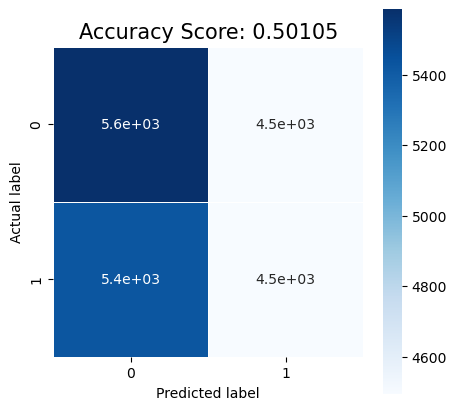

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(xgb_model.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

# Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=5, n_estimators=100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print("Accuracy Score :", accuracy_score(y_test, y_pred)*100, "%")

Accuracy Score : 49.935 %


In [26]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = rfc.predict(X_test)
print("Classification report - n", classification_report(y_test,y_pred))

Classification report - n               precision    recall  f1-score   support

           0       0.50      0.63      0.56     10079
           1       0.49      0.37      0.42      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.49     20000
weighted avg       0.50      0.50      0.49     20000



In [27]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rfc, X_train, y_train, cv=5, scoring='accuracy')
print("Average CV Accuracy: {:.2f}%".format(scores.mean() * 100))
print("Standard Deviation of CV Accuracy: {:.2f}".format(scores.std()))

Average CV Accuracy: 50.09%
Standard Deviation of CV Accuracy: 0.00


In [ ]:
param_dist = {
    'n_estimators': [100,200,300],  
    'max_depth': [3,4,5],                       
}
random_search = RandomizedSearchCV(
    estimator=rfc, 
    param_distributions=param_dist, 
    n_iter=9, 
    scoring='accuracy', 
    cv=5
)
random_search.fit(X_train, y_train)
print("Best Hyperparameters:", random_search.best_params_)
print("Best Accuracy Score:", random_search.best_score_)

Text(0.5, 1.0, 'Accuracy Score: 0.5018')

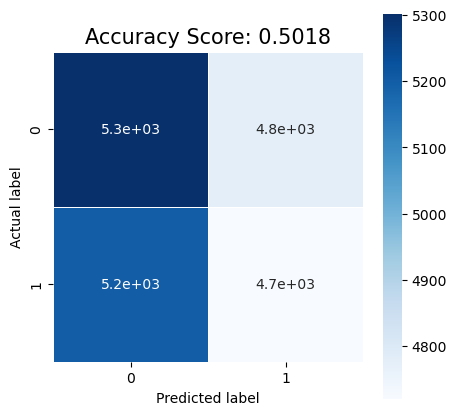

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(rfc.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

In [81]:
import joblib
with open('rfc.pkl', 'wb') as model_file:
    joblib.dump(rfc, model_file)

# New Customer Prediction

In [82]:
rf_model = joblib.load('rfc.pkl')
new_customer_data = {
    'Age': 42,
    'Gender': 1,
    'Location': 3,
    'Subscription_Length_Months': 24,
    'Monthly_Bill': 80.0,
    'Total_Usage_GB': 300,
    'Age_Monthly_Bill_Interact': 42 * 80.0,
    'Avg_Bill_By_Location': 75.0, 
    'Usage_Per_Month': 12.5,  
}
preprocessed_new_data = [
    new_customer_data['Age'],
    new_customer_data['Gender'],
    new_customer_data['Location'],
    new_customer_data['Subscription_Length_Months'],
    new_customer_data['Monthly_Bill'],
    new_customer_data['Total_Usage_GB'],
    new_customer_data['Age_Monthly_Bill_Interact'],
    new_customer_data['Avg_Bill_By_Location'],
    new_customer_data['Usage_Per_Month']
]

prediction = rf_model.predict([preprocessed_new_data])[0]
if prediction == 0:
    churn_prediction = "Not Churn"
else:
    churn_prediction = "Churn"

print("Churn Prediction:", churn_prediction)

Churn Prediction: Not Churn


C:\Users\91741\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [1]:
rf_model = joblib.load('rfc.pkl')
preprocessed_new_data = [10,0,1,21,41.0,265,45,41.0,45]
prediction = rf_model.predict([preprocessed_new_data])[0]
if prediction == 0:
    churn_prediction = "Not Churn"
else:
    churn_prediction = "Churn"

print("Churn Prediction:", churn_prediction)

NameError: name 'joblib' is not defined